# Environment

In [22]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from image_manipulation.models.conv_aec import LitConvAutoEncoder
from image_manipulation.datasets.mnist import MnistDataset
from image_manipulation.scripts.utils import load_model_from_ckpt
import torch
import plotly.express as px
import pandas as pd

# Code

In [2]:
# load model and MNIST val_dataloader
model_name = "conv_aec"
weights = "../training/conv_aec.ckpt"
model = load_model_from_ckpt(model_name, weights)
_, val_data = MnistDataset(batch_size=1).get_dataloaders()

In [8]:
# compute embeddings of val_data
embeddings = []
lbls = []
for im, lbl in val_data:
    embeddings.append(model.embeddings(im).view(len(im), -1))
    lbls.extend(lbl)
embeddings = torch.cat(embeddings).cpu().detach().numpy()

In [14]:
# convert in 2D space using tsne
tsne = TSNE(2)
clustered = tsne.fit_transform(embeddings)

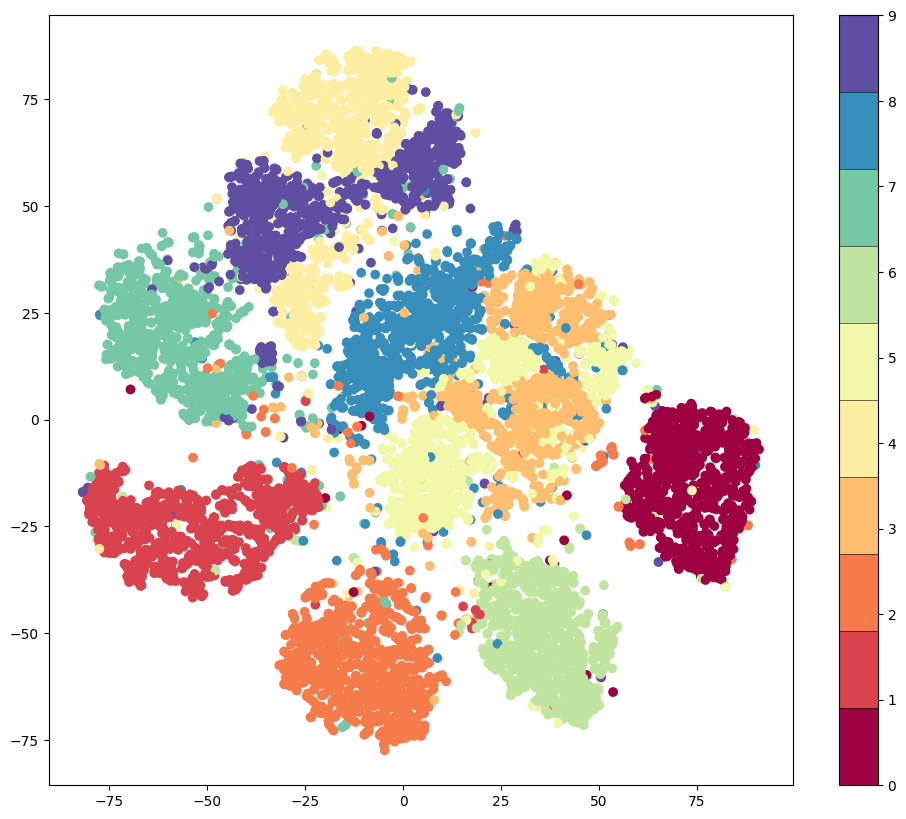

In [18]:
# plot data in 2D space
fig = plt.figure(figsize=(12,10))
cmap = plt.get_cmap('Spectral', 10)
plt.scatter(*zip(*clustered), c=lbls, cmap=cmap)
plt.colorbar(drawedges=True)

In [57]:
# plot using plotly
clss = [x.item() for x in lbls]
idxs = list(range(len(clss)))
d = {
    "id": idxs,
    "label": clss,
    "x_embed": clustered[:,0],
    "y_embed": clustered[:,1]
}
df = pd.DataFrame.from_dict(d)
fig = px.scatter(
    df,
    x = "x_embed",
    y = "y_embed",
    hover_name="id",
    labels={"id": "id"},
    color="label"
)
fig.update_layout(height=800)
fig.show()